In [90]:
import pandas as pd
import aictools.jupyter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
# model evaluation to check performance

def modelevaluation(y_test, y_pred):

    print("Confusion Matrix")
    ## TN FP
    ## FN TP

    print("{0}".format(metrics.confusion_matrix(y_test, y_pred)))
    
    print("")

    print("Accuracy : {0:4f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Precision : {0:4f}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall : {0:4f}".format(metrics.recall_score(y_test, y_pred)))
    print("F1 : {0:4f}".format(metrics.f1_score(y_test, y_pred)))

In [3]:
# gini score from kaggle

def gini(y_actual,y_pred):
    return 2*metrics.roc_auc_score(y_actual,y_pred[:,1])-1

gini_scorer=metrics.make_scorer(gini,needs_proba=True)

In [56]:
def ROC_Curve_Plot(fpr,tpr,name):

    plt.subplots_adjust(hspace=0.7)
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    plt.plot(fpr,tpr, label=name)
    plt.legend(loc='best')
    
    
    
    plt.show()

# Read and Set Data Types

In [66]:
df_orig = pd.read_csv(r"/home/rachas/PycharmProjects/Competitions/train.csv", na_values=-1)
df = df_orig.copy()

df_test = pd.read_csv(r"/home/rachas/PycharmProjects/Competitions/test.csv", na_values=-1)

In [67]:
df.shape

(595212, 59)

In [68]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
aictools.jupyter.display_summary_statistics(df)

In [69]:
# set data types based on column labels

for column in df:
    if "bin" in column:
        df[column] = df[column].astype('bool')
    if "cat" in column:
        df[column] = df[column].astype('category')

train_float = df.select_dtypes(include=['float64'])
train_int = df.select_dtypes(include=['int64'])

# EDA

In [ ]:
# Look at pearson correlation for integer type features

colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of integer features', y=1.05, size=15)
sns.heatmap(train_int.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
# Look at pearson correlation for float type features

colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of float features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
#Pick out correlated features based on score and number of missing values
corr_features = ["ps_reg_03", "ps_car_13", "ps_car_14", "ps_ind_14"]

In [ ]:
#Create bar graph function to count number of target

def BarGraphforTarget(ColumnTitle):
    
    CategoryOptions = df[ColumnTitle].dropna().value_counts().index.tolist()

    #initalise
    total_fail = pd.Series(index=CategoryOptions)
    total_pass = pd.Series(index=CategoryOptions)

    #populate
    total_fail = total_fail.add(df[df['target']== True][ColumnTitle].value_counts(normalize=False).sort_index(),
                            fill_value=0)

    total_pass = total_pass.add(df[df['target']== False][ColumnTitle].value_counts(normalize=False).sort_index(),
                            fill_value=0)

    #create graph
    ind = [x for x, _ in enumerate(CategoryOptions)]
    
    plt.bar(ind, total_fail, width=0.8, label = 'Fail', color = 'red')
    plt.bar(ind, total_pass, width=0.8, label = 'Pass', color = 'green', bottom = total_fail)

    plt.xticks(ind, CategoryOptions)
    plt.ylabel('Number of Entries')
    plt.xlabel(ColumnTitle)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.legend(loc='upper right')
    plt.title(ColumnTitle + ' that target is T/F')

    plt.show()
    
    return;


#Create bar graph function to count number of target, normalised

def BarGraphforTargetNormalised(ColumnTitle):
  
    CategoryOptions = df[ColumnTitle].dropna().value_counts().index.tolist()

    #initalise
    total_fail = pd.Series(index=CategoryOptions)
    total_pass = pd.Series(index=CategoryOptions)

    #populate
    total_fail = total_fail.add(df[df['target']== True][ColumnTitle].value_counts(normalize=False).sort_index(),
                            fill_value=0)

    total_pass = total_pass.add(df[df['target']== False][ColumnTitle].value_counts(normalize=False).sort_index(),
                            fill_value=0)
    
        
    total_temp = total_fail + total_pass
    total = total_temp.sort_index()
    
    prop_fail = ((total_fail/total) * 100).sort_index()
    prop_pass = ((total_pass/total) * 100).sort_index()

    #create graph
    ind = [x for x, _ in enumerate(CategoryOptions)]
    
    plt.bar(ind, prop_fail, width=0.8, label = 'Fail', color = 'lightcoral')
    plt.bar(ind, prop_pass, width=0.8, label = 'Pass', color = 'lightgreen', bottom = prop_fail)

    plt.xticks(ind, CategoryOptions)
    plt.ylabel('Number of Entries')
    plt.xlabel(ColumnTitle)
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.legend(loc='upper right')
    plt.title(ColumnTitle + ' that target is T/F by Proportion')
    plt.ylim=1.0

    plt.show()

    return;

In [ ]:
#Print bar graphs for all bolean type features

for column in df:
    if df[column].dtype == np.bool:
        
        BarGraphforTarget(column)
        BarGraphforTargetNormalised(column)
        

In [ ]:
#Print bar graphs for all category type features

for column in df:
    if "cat" in column:
        
        BarGraphforTarget(column)
        BarGraphforTargetNormalised(column)

In [ ]:
#Create function for formatted histogram

def HistogramFigure(ColumnTitle, NoBins):
    
    plt.subplots_adjust(hspace=0.7)
    
    plt.subplot(311)
    plt.title(ColumnTitle + ' Histogram of Total')
    plt.hist(df[ColumnTitle].dropna(), NoBins, normed=1, facecolor='black', alpha=0.75)
    
    plt.subplot(312)
    plt.title(ColumnTitle + 'Histogram of Fails')    
    plt.hist(df[df['target']== True][ColumnTitle].dropna(), NoBins, normed=1, facecolor='red', alpha=0.75)
    
    plt.subplot(313)
    plt.title(ColumnTitle + ' Histogram of Passes')
    plt.hist(df[df['target']== False][ColumnTitle].dropna(), NoBins, normed=1, facecolor='green', alpha=0.75)
    
    plt.show()
    
    return;

In [ ]:
for column in df:
    if ((df[column].dtype == np.float64) and (column != "target") and (column != "id")):
        
        HistogramFigure(column,50)

In [ ]:
for column in df:
    if ((df[column].dtype == np.int64) and (column != "target") and (column != "id")):
        
        HistogramFigure(column,50)

In [ ]:
#Create function for formatted scatter plot of feature vs target

def ScatterFeatureTargetFigure(ColumnTitle, Target):
    
    
    
    
    plt.scatter(df[ColumnTitle],df[Target], c = "b", alpha = 0.75)

    plt.title(ColumnTitle + ' scatter vs ' + Target)
  
    plt.show()
    
    return;

# Feature Engineering

### Deal with Missing Values

In [23]:
# drop rows with missing values
#df = df.dropna()

### Select Features

In [70]:
ind_features = []
reg_features = []
car_features = []
calc_features = []

for column in df:
    
    if "ind" in column:
        ind_features += [column]
    if "reg" in column:
        reg_features += [column]
    if "car" in column:
        car_features += [column]
    if "calc" in column:
        calc_features += [column]

In [71]:
target_feature = ["target"]

In [72]:
df_selection = df[ind_features + reg_features + car_features + calc_features+target_feature]

In [73]:
y = df_selection[target_feature[0]]
X_select = df_selection.drop(target_feature, axis=1)

In [74]:
#Make sure same number of rows
print(X_select.shape)
print(y.shape)

(595212, 57)
(595212,)


### one hot code columns

In [75]:
# split categorical columns into binary columns
X = pd.get_dummies(X_select)
X.shape

(595212, 218)

# Split Data

In [49]:
split_test_size = 0.3

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size = split_test_size, random_state = 42)

In [50]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index))*100))
print("{0:0.2f}% in training set".format((len(X_test)/len(df.index))*100))

70.00% in training set
30.00% in training set


In [51]:
num_true = len(df.loc[df[target_feature[0]] == True])
num_false = len(df.loc[df[target_feature[0]] == False])

print("Original True: {0} ({1:2.2f}%)".format(num_true, (100 * num_true/(num_true + num_false))))
print("Original False: {0} ({1:2.2f}%)".format(num_false, (100 * num_false/(num_true + num_false))))
print("Original X: {0}".format(X.shape))
print("Original Y: {0}".format(y.shape))
print("")

num_true = len(y_train[y_train[:] == True])
num_false = len(y_train[y_train[:] == False])

print("Training True: {0} ({1:2.2f}%)".format(num_true, (100 * num_true/(num_true + num_false))))
print("Training False: {0} ({1:2.2f}%)".format(num_false, (100 * num_false/(num_true + num_false))))
print("Training X: {0}".format(X_train.shape))
print("Training Y: {0}".format(y_train.shape))
print("")

num_true = len(y_test[y_test[:] == True])
num_false = len(y_test[y_test[:] == False])

print("Test True: {0} ({1:2.2f}%)".format(num_true, (100 * num_true/(num_true + num_false))))
print("Test False: {0} ({1:2.2f}%)".format(num_false, (100 * num_false/(num_true + num_false))))
print("Test X: {0}".format(X_test.shape))
print("Test Y: {0}".format(y_test.shape))
print("")

Original True: 21694 (3.64%)
Original False: 573518 (96.36%)
Original X: (595212, 57)
Original Y: (595212,)

Training True: 15109 (3.63%)
Training False: 401539 (96.37%)
Training X: (416648, 57)
Training Y: (416648,)

Test True: 6585 (3.69%)
Test False: 171979 (96.31%)
Test X: (178564, 57)
Test Y: (178564,)



# Baseline Model - Naive Bayes

In [85]:
pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('NB', GaussianNB())])

pipe.fit(X_train, y_train)

y_nb = pipe.predict_proba(X_test)


In [86]:
gini(y_test, y_nb)

0.22512971346296751

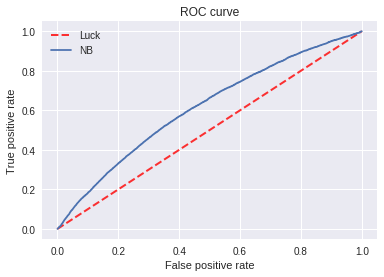

In [87]:
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test,y_nb[:,1])

ROC_Curve_Plot(fpr_nb,tpr_nb,"NB")

# Only Calc Features

In [ ]:
X_calc = X

for column in X_calc:
    if "calc" not in column:
        X_calc=X_calc.drop(column, axis = 1)

In [ ]:
X_calc.head()

In [ ]:
pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('NB', GaussianNB())])

pipe.fit(X_calc, y)

y_NB_calc = model_selection.cross_val_predict(pipe,X_calc, y, method="predict_proba")

In [ ]:
gini(y,y_NB_calc)

In [ ]:
fpr_NB_calc, tpr_NB_calc, _ = metrics.roc_curve(y,y_NB_calc[:,1])

ROC_Curve_Plot(fpr_NB_calc,tpr_NB_calc,"NB")

## Outlier play

In [ ]:
pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('NB', GaussianNB())])

pipe.fit(X, y)

y_op = pipe.predict_proba(X)

In [ ]:
y_op = pd.DataFrame(y_op)
combined_df = pd.concat([y_op, df], axis=1)
combined_df = combined_df.rename(index=str, columns={0:"Predict_0", 1:"Predict_1"})
combined_df = combined_df.assign(OutlierError=0)

In [ ]:
combined_df.head()

In [ ]:
combined_df['OutlierError'] = np.where(combined_df['target']==0, combined_df["Predict_1"], combined_df["Predict_0"])

In [ ]:
import seaborn as sns

In [ ]:
#Create function for formatted scatter plot of feature vs target

def OutlierFigure_2(df, ColumnTitle, Outlier, Target, MinorityTarget):
    
    categories = np.unique(df[Target])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))
    df["Color"] = df[Target].apply(lambda x: colordict[x])
    
    plt.scatter(df[ColumnTitle],df[Outlier], c = df.Color, alpha = 0.1)

    plt.title(ColumnTitle + ' scatter vs ' + Target)
  
    plt.show()
    
    return;

    import seaborn


In [ ]:
def OutlierFigure_sns(df, ColumnTitle, Outlier, Target, MinorityTarget):

    sns.set(style='ticks')


    fg = sns.FacetGrid(data=df, hue=Target, aspect=1.61)
    fg.map(plt.scatter, ColumnTitle, Outlier).add_legend()

In [ ]:
OutlierFigure_sns(combined_df, "ps_calc_14", "OutlierError", "target", 1 )

In [ ]:
for column in df:
     if ((df[column].dtype == np.int64) and (column != "target") and (column != "id")):
        
        OutlierFigure_sns(combined_df, column, "OutlierError", "target", 1 )

# Regularized Naive Bayes

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('RF', RandomForestClassifier(random_state=42, min_samples_leaf=0.01, n_estimators = 25))])

#pipe.fit(X, y)

#y_rf = pipe.predict_proba(X_test)

#y_rf = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

In [ ]:
fpr_rf, tpr_rf, _ = metrics.roc_curve(y,y_rf[:,1])

ROC_Curve_Plot(fpr_rf, tpr_rf, "RF")

In [ ]:
gini(y,y_rf)

In [ ]:
param_grid = {"RF__n_estimators": [15,20,25,30]}

grid_search = model_selection.GridSearchCV(pipe, param_grid, cv = cv, scoring=gini_scorer)

grid_search.fit(X,y)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
#pipe.predict_proba(X_test)

# Random Forest - without >0.5 correlated features

In [ ]:
X_cf = pd.get_dummies(X_select.drop(corr_features, axis=1))
X_cf.shape

In [ ]:
pipe = pipeline.Pipeline([
    ('RF', RandomForestClassifier(random_state=42))])

#y_RF_cf = pipe.fit(X_cf, y).predict_proba(X_cf)
y_rf_cf = model_selection.cross_val_predict(pipe,X_cf,y, method = "predict_proba")

In [ ]:
gini(y,y_rf_cf)

In [ ]:
fpr_rf_cf, tpr_rf_cf, _ = metrics.roc_curve(y,y_rf_cf[:,1])

ROC_Curve_Plot(fpr_rf_cf, tpr_rf_cf, "RF")

# Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('Adaboost', AdaBoostClassifier(random_state=42))])

#pipe.fit(X, y)

#y_rf = pipe.predict_proba(X_test)

#y_ab = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

In [ ]:
fpr_ab, tpr_ab, _ = metrics.roc_curve(y,y_ab[:,1])

ROC_Curve_Plot(fpr_ab, tpr_ab, "RF")

In [ ]:
gini(y,y_ab)

# Gradient Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('GradientBoosting', GradientBoostingClassifier())])

pipe.fit(X, y)

#y_gb = pipe.predict_proba(X_test)

y_gb = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

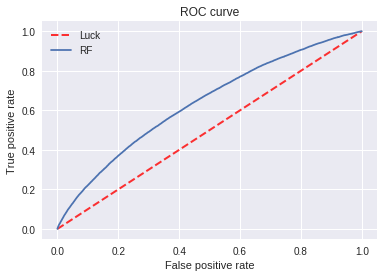

In [57]:
fpr_gb, tpr_gb, _ = metrics.roc_curve(y,y_gb[:,1])

ROC_Curve_Plot(fpr_gb, tpr_gb, "RF")

In [58]:
gini(y,y_gb)

0.27371818669566839

In [59]:
pipe

Pipeline(steps=[('Replace Missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('GradientBoosting', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_no...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])

# Gradient Boosting Tweaked

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

There are two types of parameter to be tuned here – tree based and boosting parameters. There are no optimum values for learning rate as low values always work better, given that we train on sufficient number of trees.

Though, GBM is robust enough to not overfit with increasing trees, but a high number for pa particular learning rate can lead to overfitting. But as we reduce the learning rate and increase trees, the computation becomes expensive and would take a long time to run on standard personal computers.

- Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
- Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
- Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
- Lower the learning rate and increase the estimators proportionally to get more robust models.

min_samples_split = 3000 : This should be ~0.5-1% of total values[read rows]. Since this is imbalanced class problem, we’ll take a small value from the range.

min_samples_leaf = 300 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.

max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.

max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
subsample = 0.8 : This is a commonly used used start value

In [ ]:
cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('GradientBoosting', GradientBoostingClassifier(learning_rate=0.1,
                            min_samples_split=3000, min_samples_leaf = 300, max_depth = 8, max_features ="sqrt",
                            subsample=0.8, random_state=42))])

In [ ]:
pipe.fit(X, y)

#y_rf = pipe.predict_proba(X_test)

y_gb = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

In [ ]:
# Find the optimum number of estimators
%time

param_test1 = {'GradientBoosting__n_estimators':range(20,81,10)}

gsearch1 = model_selection.GridSearchCV(pipe, param_grid = param_test1,
                                        scoring=gini_scorer, n_jobs=4, iid=False, cv=cv)

gsearch1.fit(X,y)

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Trying higher learning rate to decrease n_estimators

In [ ]:
pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('GradientBoosting', GradientBoostingClassifier(learning_rate=0.15,
                            min_samples_split=3000, min_samples_leaf = 300, max_depth = 8, max_features ="sqrt",
                            subsample=0.8, random_state=42))])

In [ ]:
# Find the optimum number of estimators
%time

param_test1 = {'GradientBoosting__n_estimators':range(20,101,10)}

gsearch1 = model_selection.GridSearchCV(pipe, param_grid = param_test1,
                                        scoring=gini_scorer, n_jobs=4, iid=False, cv=cv)

gsearch1.fit(X,y)

In [ ]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Now set learning rate and n_estimators, and tune other parameters.

In [ ]:
pipe2 = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('GradientBoosting', GradientBoostingClassifier(learning_rate=0.15, n_estimators = 50,
                                                    max_features ="sqrt", subsample=0.8, random_state=42))])

In [ ]:
param_test2 = {'GradientBoosting__max_depth':range(5,16,2), 'GradientBoosting__min_samples_split':range(2000,5001,1000)}

gsearch2 = model_selection.GridSearchCV(pipe2, param_grid = param_test2,
                                        scoring=gini_scorer,n_jobs=4,iid=False, cv=cv)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

# Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
clf1 = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('RF', RandomForestClassifier(random_state=42, min_samples_leaf=0.01, n_estimators = 25))])

clf2 = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('Adaboost', AdaBoostClassifier(random_state=42))])

clf3 = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('GradientBoosting', GradientBoostingClassifier(learning_rate=0.1,
                            min_samples_split=3000, min_samples_leaf = 300, max_depth = 8, max_features ="sqrt",
                            subsample=0.8, random_state=42))])
Voting_Classifier = VotingClassifier([("RF",clf1),("Adaboost",clf2),("GradientBoost",clf3)],voting="soft",n_jobs=-1,)

Voting_Classifier.fit(X,y)

In [ ]:
y_VC = model_selection.cross_val_predict(Voting_Classifier,X, y, method="predict_proba")

In [ ]:
fpr_vc, tpr_vc, _ = metrics.roc_curve(y,y_VC[:,1])

ROC_Curve_Plot(fpr_vc, tpr_vc, "VC")

In [ ]:
gini(y,y_VC)

# PCA

In [79]:
X.shape

(595212, 218)

In [105]:
n_components = 5

cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('StandardScalar', preprocessing.StandardScaler()),
    ('Apply PCA', PCA(n_components=n_components, whiten=True)),
    ('GradientBoosting', GradientBoostingClassifier())])

pipe.fit(X, y)

#y_gb = pipe.predict_proba(X_test)

y_gb_pca = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

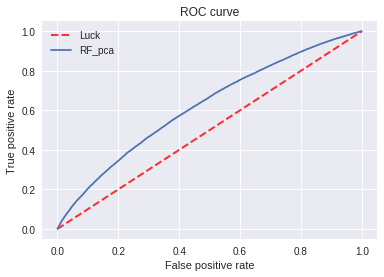

In [83]:
fpr_gb_pca, tpr_gb_pca, _ = metrics.roc_curve(y,y_gb_pca[:,1])

ROC_Curve_Plot(fpr_gb_pca, tpr_gb_pca, "RF_pca")

In [106]:
gini(y,y_gb_pca)

0.20293897034158759

# Naive Bayes PCA

In [111]:
cv = model_selection.KFold(n_splits=5, shuffle=False)

pipe = pipeline.Pipeline([
    ('Replace Missing', preprocessing.Imputer(strategy="median")),
    ('StandardScalar', preprocessing.StandardScaler()),
    ('Apply_PCA', PCA(whiten=True)),
    ('NB', GaussianNB())])

pipe.fit(X, y)

#y_gb = pipe.predict_proba(X_test)

#y_gb_pca = model_selection.cross_val_predict(pipe,X, y, method="predict_proba")

Pipeline(steps=[('Replace Missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StandardScalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Apply_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('NB', GaussianNB(priors=None))])

In [97]:
param_test3 = {'Apply_PCA__n_components':range(40,220,40)}
estimator = GridSearchCV(pipe, param_test3, scoring=gini_scorer)

estimator.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('Replace Missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StandardScalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Apply_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('NB', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Apply_PCA__n_components': range(40, 220, 40)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(gini, needs_proba=True), verbose=0)

In [98]:
estimator.grid_scores_, estimator.best_params_, estimator.best_score_

/home/rachas/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.19071, std: 0.00384, params: {'Apply_PCA__n_components': 40},
  mean: 0.16824, std: 0.00280, params: {'Apply_PCA__n_components': 80},
  mean: 0.14775, std: 0.00476, params: {'Apply_PCA__n_components': 120},
  mean: 0.14216, std: 0.00368, params: {'Apply_PCA__n_components': 160},
  mean: 0.16927, std: 0.00534, params: {'Apply_PCA__n_components': 200}],
 {'Apply_PCA__n_components': 40},
 0.19071075128121925)

In [99]:
estimator.cv_results_

{'mean_fit_time': array([ 23.13128996,  26.94368108,  31.6810619 ,  37.07218663,  25.23367858]),
 'mean_score_time': array([ 2.63416799,  2.90103761,  3.1209662 ,  3.48107211,  3.64019386]),
 'mean_test_score': array([ 0.19071075,  0.1682372 ,  0.14775026,  0.1421583 ,  0.16927187]),
 'mean_train_score': array([ 0.19112951,  0.16873143,  0.1510746 ,  0.14509665,  0.17229034]),
 'param_Apply_PCA__n_components': masked_array(data = [40 80 120 160 200],
              mask = [False False False False False],
        fill_value = ?),
 'params': ({'Apply_PCA__n_components': 40},
  {'Apply_PCA__n_components': 80},
  {'Apply_PCA__n_components': 120},
  {'Apply_PCA__n_components': 160},
  {'Apply_PCA__n_components': 200}),
 'rank_test_score': array([1, 3, 4, 5, 2], dtype=int32),
 'split0_test_score': array([ 0.19613766,  0.16658953,  0.14747143,  0.14079019,  0.16897355]),
 'split0_train_score': array([ 0.19036333,  0.16405658,  0.14953153,  0.14444953,  0.17361445]),
 'split1_test_score': array

In [112]:
param_test4 = {'Apply_PCA__n_components':range(10,40,10)}
estimator2 = GridSearchCV(pipe, param_test4, scoring=gini_scorer)

estimator2.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('Replace Missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StandardScalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Apply_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('NB', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Apply_PCA__n_components': range(10, 40, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(gini, needs_proba=True), verbose=0)

In [113]:
estimator2.best_params_, estimator2.best_score_

({'Apply_PCA__n_components': 30}, 0.1913807822058681)

In [103]:
param_test5 = {'Apply_PCA__n_components':range(1,10,1)}
estimator3 = GridSearchCV(pipe, param_test5, scoring=gini_scorer)

estimator3.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('Replace Missing', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StandardScalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Apply_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('NB', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Apply_PCA__n_components': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(gini, needs_proba=True), verbose=0)

In [104]:
estimator3.best_params_, estimator3.best_score_

({'Apply_PCA__n_components': 5}, 0.18355181998240644)

# Output Results

## Prep Data and Get Results

In [ ]:
for column in df_test:
    if "bin" in column:
        df_test[column] = df_test[column].astype('bool')
    if "cat" in column:
        df_test[column] = df_test[column].astype('category')

In [ ]:
X_test = pd.get_dummies(df_test)

In [ ]:
X_test = X_test.drop("id", axis=1)

In [ ]:
y_test = Voting_Classifier.predict_proba(X_test)

## Format for Submission

In [ ]:
submit_id = pd.DataFrame(df_test["id"])

1488026

In [ ]:
submit_values = pd.DataFrame(y_test[:,1])

In [ ]:
submit = pd.concat([submit_id,submit_values], axis=1)

In [ ]:
submit = submit.rename(index=str, columns={0:"target"})

In [ ]:
submit.tail()

In [ ]:
submit.to_csv(r"/home/rachas/PycharmProjects/Competitions/submission_VC.csv",index=False)